- read datasets, potentially using sql query if it doesn't take long
- do my own basic explorations, compare to Hauke's
- Visualize labels
- IoU

In [316]:
# Imports
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
import matplotlib.patches as patches
from PIL import Image
import pdb
import seaborn as sns
import itertools

## Read  and preprocess dataset

In [4]:
### Functions from https://github.com/zooniverse/Data-digging/blob/master/example_scripts/astronomy_rewind/workflow1to2.py

def JSONParser(data):
    """call json.loads"""
    return json.loads(data)


def load_classifications(filename, json_columns=None):
    """
    Load classifications into pandas dataframe.
    Some columns of the csv are embedded json and need special parsing.
    """
    json_columns = json_columns or ['metadata', 'annotations', 'subject_data']
    converters = {i: JSONParser for i in json_columns}

    return pd.read_csv(filename, converters=converters)

def unpack(series):
    """
    Return the first value in a series.
    All annotations values are lists because of a few multiple tasks.
    The second multiple task always has the value of 'None of the above'
    (For this dataset!)
    """
    return [a[0] for a in series]


def parse_classifications(filename,**kwarg):
    """
    Load classifications and datamunge annotations column.
    """
    data = load_classifications(filename,**kwarg)

    # Only need the first item in the annotations list of json objects
    data['annotations'] = unpack(data['annotations'])
    return data

In [5]:
clas_fn = '../zooniverse_raw/sugar-flower-fish-or-gravel-classifications_18_11_02.csv'
subj_fn = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'

### Split into practice and full dataset files and only take files from the actual classification day.

In [14]:
clas = parse_classifications(clas_fn,json_columns=['metadata', 'annotations', 'subject_data'])

In [24]:
subj = load_classifications(subj_fn)

In [16]:
clas['datetime'] = pd.to_datetime(clas['created_at'])

In [17]:
clas = clas[clas['datetime'].dt.date == np.datetime64('2018-11-02')]

In [18]:
# How many labels for annotation
clas['num_boxes'] = clas['annotations'].apply(lambda x: len(x['value']))

/home/s/S.Rasp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
clas['num_boxes'].hist(bins=np.arange(13))

In [20]:
prac = clas[clas['workflow_name'] == 'Practice']
full = clas[clas['workflow_name'] == 'Full dataset']

In [21]:
len(prac), len(full)

(2116, 17469)

### Prepare some helpful dictionaries

In [52]:
classes = ['Sugar', 'Flower', 'Fish', 'Gravel']

In [26]:
subjects_name = {60811:'BCO_DJF_Aqua',60812:'BCO_DJF_Terra',60813: 'BCO_MAM_Aqua',\
                 60814: 'BCO_MAM_Terra',60815:'R2_DJF_Aqua',60816:'R2_DJF_Terra',\
                 60817:'R3_DJF_Aqua', 60818:'R3_DJF_Terra',60819:'R3_SON_Aqua',\
                 60835: 'R3_SON_Terra'}

In [27]:
subj2fn = {}
for i, r in subj.iterrows():
    if r['subject_set_id'] in list(subjects_name.keys()):
        subj2fn[r['subject_id']] =  r['metadata']['fn']

In [61]:
subjects = list(subj2fn.keys())

In [295]:
img.size

(2100, 1400)

In [296]:
image_width = 2100
image_height = 1400

In [300]:
# Dictionary for every subject containing all annotations (also empty ones!)
annos = defaultdict(list)
for i, r in full.iterrows():
    if len(r['annotations']['value']) > 0 :
        for a in r['annotations']['value']:
            x = np.max([0., a['x']]); y = np.max([0., a['y']])
            w = np.min([image_width - a['x'], a['width']])
            h = np.min([image_height - a['y'], a['height']])
            annos[r['subject_ids']].append([
                r['user_name'],
                [x, y, w, h],
                a['tool_label']
            ])
    else:   # No annotation
        annos[r['subject_ids']].append([
            r['user_name'],
            [None, None, None, None],
            None
        ])

In [301]:
annos_prac = defaultdict(list)
for i, r in prac.iterrows():
    if len(r['annotations']['value']) > 0 :
        for a in r['annotations']['value']:
            x = np.max([0., a['x']]); y = np.max([0., a['y']])
            w = np.min([image_width - a['x'], a['width']])
            h = np.min([image_height - a['y'], a['height']])
            annos_prac[r['subject_ids']].append([
                r['user_name'],
                [x, y, w, h],
                a['tool_label']
            ])
    else:   # No annotation
        annos_prac[r['subject_ids']].append([
            r['user_name'],
            [None, None, None, None],
            None
        ])

In [250]:
subjects_prac = list(annos_prac.keys()); len(subjects_prac)

50

## Plotting

In [381]:
s=subjects_prac[28]

In [382]:
def plot_with_annos(subject_id, annos=annos, users=None):
    fig, ax = plt.subplots(figsize=(15, 10))
    img = Image.open(subj2fn[subject_id])
    ax.imshow(img)
    nones = []
    for a in annos[s]:
        if a[2] is not None:
            if users is not None and a[0] in users:
                coords = a[1]
                rect = patches.Rectangle((coords[0],coords[1]), coords[2], coords[3], facecolor='none', edgecolor='r')
                ax.add_patch(rect)
                ax.text(coords[0],coords[1], a[2] + ' - ' + a[0], color='red', fontsize=15, va='top')
        else:
            nones.append(a[0])
    if len(nones) > 0:
        ax.text(0, -50, 'None: ' + str(nones), color='red', fontsize=15, va='top')

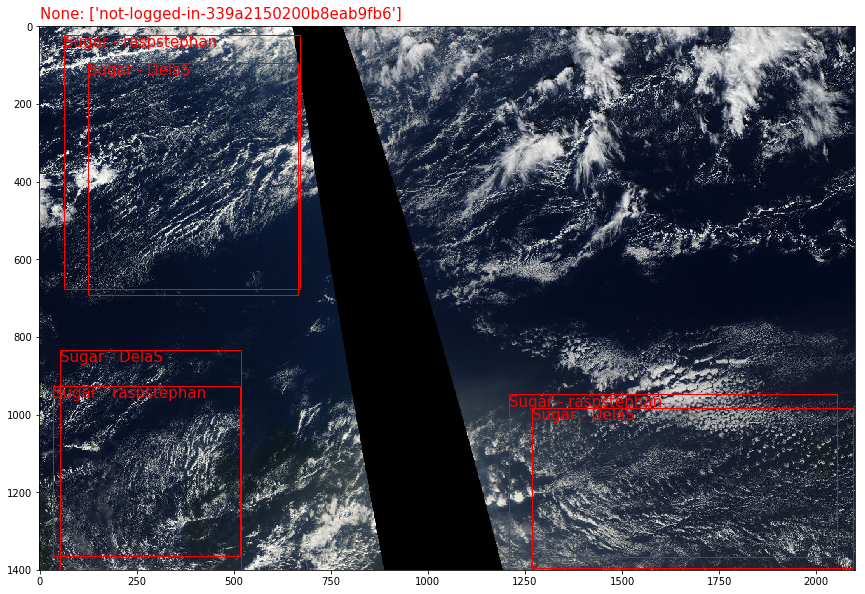

In [403]:
plot_with_annos(s, annos_prac, ['raspstephan', 'DelaS'])

## IoU Score

In [413]:
prac['user_name'].unique()

array(['jkiliani', 'ReinhardB', 'bjorn.stevens', 'TobiasBecker',
       'lutz.hirsch', 'cathyhohenegger', 'Uthlande', 'jan.welss',
       'Julia.Windmiller', 'kfodor', 'not-logged-in-acafbd8be3e0c307f3bf',
       'christopher.moseley', 'dleutwyler', 'hartmut.borth', 'heikekonow',
       'biancorosa', 'lkluft', 'onnoq',
       'not-logged-in-339a2150200b8eab9fb6',
       'not-logged-in-169bca65941805c9a058', 'Wolkengebilde', 'CStephan',
       'magio', 'lpaccini', 'anna.luebke', 'tmieslinger',
       'Armin.haghshenas', 'guidocioni', 'bschul', 'MarcusKlingebiel',
       'raspstephan', 'JuleR', 'bko_cloud', 'traute.crueger', 'DelaS',
       'LWMPI', 'monika.esch', 'geetgeorge', 'bkirsch', 'majomi',
       'elessar.telkontar', 'jpmellado', 'CKauhs', 'Saybot', 'ShCu',
       'stefankinne', 'tobifinn', 'UlliK', 'double_p'], dtype=object)

In [414]:
unique_users = list(prac['user_name'].unique())

In [415]:
agreement  = defaultdict(list)
for s in subjects_prac:
    for u in unique_users:
        agreement[u].append(get_comp_data(s, 'raspstephan', u, annos_prac))

In [416]:
df = pd.DataFrame(data = {'agreement': [np.mean([a for a in agreement[u] if a is not None]) for u in unique_users]}, index=unique_users)

In [417]:
df.sort_values('agreement', axis=0, ascending=False, inplace=True)

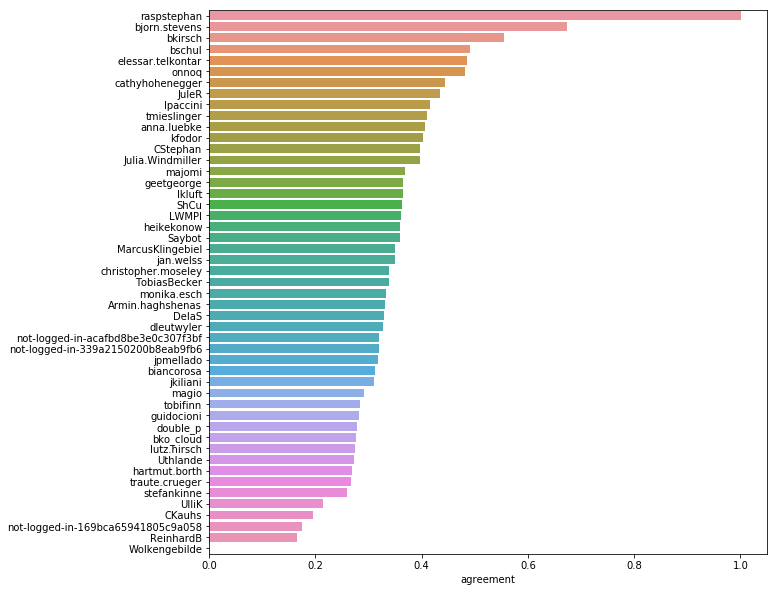

In [418]:
fig = plt.figure(figsize=(10, 10))
sns.barplot(x=df['agreement'], y=df.index)

In [319]:
get_comp_data(s, 'JuleR', 'bschul')

In [320]:
get_comp_data(s, 'bschul', 'JuleR')

In [180]:
%debug

> /home/s/S.Rasp/miniconda3/lib/python3.6/bdb.py(70)dispatch_line()
     68         if self.stop_here(frame) or self.break_here(frame):
     69             self.user_line(frame)
---> 70             if self.quitting: raise BdbQuit
     71         return self.trace_dispatch
     72 

ipdb> 


In [266]:
def get_comp_data(subject_id, user1, user2, annos=annos):
    subj_annos = annos[subject_id]
    users = list(set([a[0] for a in subj_annos]))
    if user1 in users and user2 in users:
        annos1 = [a[1:] for a in subj_annos if a[0] == user1]
        annos2 = [a[1:] for a in subj_annos if a[0] == user2]
        if annos1[0][1] is None and annos2[0][1] is None:
            iou = 1.
        elif annos1[0][1] is None:
            iou = 0.
        elif annos2[0][1] is None:
            iou = 0.
        else:
            iou = iou_multi_class(annos1, annos2)
        return iou
    else:
        return None

In [262]:
def iou_multi_class(annos1, annos2):
    """For two users"""
    i_tot = 0; u_tot = 0
    for c in classes:
        ac1 = [a[0] for a in annos1 if a[1] == c]
        ac2 = [a[0] for a in annos2 if a[1] == c]
        if len(ac1) == 0 and len(ac2) == 0:   # None of the users has this class
            i = 0; u = 0
        elif len(ac1) == 0 or len(ac2) == 0:
            i = 0
            u = compute_area_sum(ac1 + ac2)
        else:
            i, u = iou_one_class(ac1, ac2)
        i_tot += i; u_tot += u
    return i_tot / u_tot

In [317]:
a = [0]
itertools.combinations(a, 2)

In [395]:
def iou_one_class(annos1, annos2):
    """annos1 and annos2 are lists with the coordinates of each annotation"""
    # All permutations
    i = 0
    for a1 in annos1:
        for a2 in annos2:
            i += compute_intersect(a1, a2)
    # Need to compute the overlap between the boxes of 1 and 2
    i1 = 0; i2 = 0
    for b1, b2 in itertools.combinations(annos1, 2):
        i1 += compute_intersect(b1, b2)
    for b1, b2 in itertools.combinations(annos2, 2):
        i2 += compute_intersect(b1, b2)
    u = compute_area_sum(annos1 + annos2) - i# - i1 -i2
    
    iou = i/u  #(i - i1 - i2) / u
    return i, u

In [172]:
def wh2xy(x, y, w, h):
    return x, y, x+w, y+h

In [173]:
def compute_intersect(a1, a2):
    """https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/"""
    x1a, y1a, x2a, y2a = wh2xy(*a1)
    x1b, y1b, x2b, y2b = wh2xy(*a2)
    xA = max(x1a, x1b)
    yA = max(y1a, y1b)
    xB = min(x2a, x2b)
    yB = min(y2a, y2b)
    i = max(0, xB - xA) * max(0, yB - yA) # max(0, xB - xA + 1) * max(0, yB - yA + 1)
    return i

In [174]:
def compute_area_sum(annos):
    areas = [a[2] * a[3] for a in annos]
    return np.sum(areas)

In [142]:
a1 = [113.23209381103516,
                296.8004150390625,
                1779.1966171264648,
                1087.6436767578125]
a2 = [80.33280181884766,
                355.62127685546875,
                1628.1209335327148,
                919.8423461914062]
a1 = [10, 10, 400, 400]
a2 = [10, 10, 300, 300]
a3 = [600, 600, 100, 100]

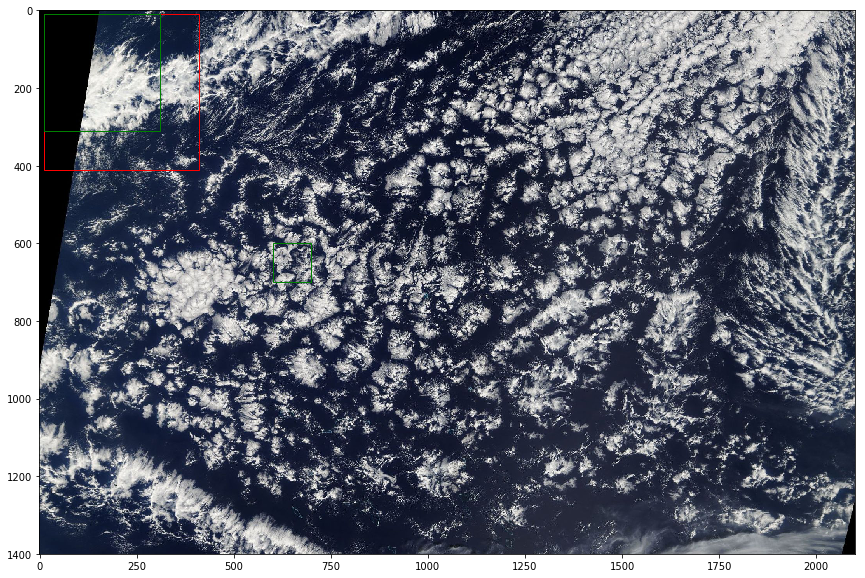

In [143]:
fig, ax = plt.subplots(figsize=(15, 10))
img = Image.open(subj2fn[27145058])
ax.imshow(img)
rect = patches.Rectangle((a1[0],a1[1]), a1[2], a1[3], facecolor='none', edgecolor='r')
ax.add_patch(rect)
rect = patches.Rectangle((a2[0],a2[1]), a2[2], a2[3], facecolor='none', edgecolor='g')
ax.add_patch(rect)
rect = patches.Rectangle((a3[0],a3[1]), a3[2], a3[3], facecolor='none', edgecolor='g')
ax.add_patch(rect)

In [144]:
i = compute_intersect(a1, a2)
a = compute_area_sum([a1, a2])
u = a - i
iou = i / u
i, a, u, iou

(90000, 250000, 160000, 0.5625)

In [145]:
iou_one_class([a1], [a2, a3])

0.5294117647058824

# Old

In [ ]:
clas['num_boxes'] = clas['annotations'].apply(lambda x: len(x['value']))

In [12]:
full

classification_id      user_name    user_id               user_ip  \
559            129698655  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
623            129698824  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
717            129699083  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
781            129699257  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
809            129699340       jkiliani  1837012.0  0487d4d9788931868f3a   
847            129699448  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
866            129699509       jkiliani  1837012.0  0487d4d9788931868f3a   
882            129699549  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
910            129699620       jkiliani  1837012.0  0487d4d9788931868f3a   
925            129699673       jkiliani  1837012.0  0487d4d9788931868f3a   
948            129699739  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
966            129699789      jan.welss  1837022.0  e551ecd6265917094e8c   
969            129699799       jkiliani  1837012.0  0487d4d9788931868f3a   
975            129699812      jan.welss  1837022.0  e551ecd6265917094e8c   
988            129699848      jan.welss  1837022.0  e551ecd6265917094e8c   
1006           129699903      jan.welss  1837022.0  e551ecd6265917094e8c   
1017           129699937      jan.welss  1837022.0  e551ecd6265917094e8c   
1036           129699986      jan.welss  1837022.0  e551ecd6265917094e8c   
1049           129700030       jkiliani  1837012.0  0487d4d9788931868f3a   
1058           129700053      jan.welss  1837022.0  e551ecd6265917094e8c   
1065           129700074       jkiliani  1837012.0  0487d4d9788931868f3a   
1093           129700146      jan.welss  1837022.0  e551ecd6265917094e8c   
1096           129700156     biancorosa  1837436.0  b3bcd67523f4a0fa3444   
1102           129700174  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
1111           129700192       jkiliani  1837012.0  0487d4d9788931868f3a   
1118           129700210     biancorosa  1837436.0  b3bcd67523f4a0fa3444   
1128           129700236      jan.welss  1837022.0  e551ecd6265917094e8c   
1136           129700256     biancorosa  1837436.0  b3bcd67523f4a0fa3444   
1146           129700281     biancorosa  1837436.0  b3bcd67523f4a0fa3444   
1151           129700292  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
...                  ...            ...        ...                   ...   
20181          129755223    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20182          129755241    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20183          129755247         bschul  1837000.0  453d89e8d2c6926a9393   
20184          129755273         bschul  1837000.0  453d89e8d2c6926a9393   
20185          129755306         bschul  1837000.0  453d89e8d2c6926a9393   
20186          129755318    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20187          129755334    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20188          129755348         bschul  1837000.0  453d89e8d2c6926a9393   
20189          129755350    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20190          129755364    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20191          129755367         bschul  1837000.0  453d89e8d2c6926a9393   
20192          129755381         bschul  1837000.0  453d89e8d2c6926a9393   
20193          129755384    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20194          129755397         bschul  1837000.0  453d89e8d2c6926a9393   
20195          129755401    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20196          129755418         bschul  1837000.0  453d89e8d2c6926a9393   
20197          129755422       jkiliani  1837012.0  0487d4d9788931868f3a   
20198          129755439    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20199          129755457         bschul  1837000.0  453d89e8d2c6926a9393   
20200          129755460    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20201          129755477    lutz.hirsch  1837010.0  28e

In [113]:
clas = parse_classifications(clas_fn,json_columns=['metadata', 'annotations', 'subject_data'])
subj = load_classifications(subj_fn); subj.head()

subject_id  project_id  workflow_id  subject_set_id  \
0    26976345        7699          NaN           60713   
1    26976346        7699          NaN           60713   
2    26976347        7699          NaN           60713   
3    26976348        7699          NaN           60713   
4    26976349        7699          NaN           60713   

                                            metadata  \
0  {'fn': '/project/meteo/work/S.Rasp/cloud-class...   
1  {'fn': '/project/meteo/work/S.Rasp/cloud-class...   
2  {'fn': '/project/meteo/work/S.Rasp/cloud-class...   
3  {'fn': '/project/meteo/work/S.Rasp/cloud-class...   
4  {'fn': '/project/meteo/work/S.Rasp/cloud-class...   

                                           locations  classifications_count  \
0  {"0":"https://panoptes-uploads.zooniverse.org/...                      0   
1  {"0":"https://panoptes-uploads.zooniverse.org/...                      0   
2  {"0":"https://panoptes-uploads.zooniverse.org/...                      0   
3  {"0":"https://panoptes-uploads.zooniverse.org/...                      0   
4  {"0":"https://panoptes-uploads.zooniverse.org/...                      0   

  retired_at retirement_reason               created_at  \
0        NaN               NaN  2018-10-24 16:42:28 UTC   
1        NaN               NaN  2018-10-24 16:42:29 UTC   
2        NaN               NaN  2018-10-24 16:42:31 UTC   
3        NaN               NaN  2018-10-24 16:42:32 UTC   
4        NaN               NaN  2018-10-24 16:42:33 UTC   

                updated_at  
0  2018-10-24 16:42:28 UTC  
1  2018-10-24 16:42:29 UTC  
2  2018-10-24 16:42:31 UTC  
3  2018-10-24 16:42:32 UTC  
4  2018-10-24 16:42:33 UTC

In [126]:
subj

subject_id  project_id  workflow_id  subject_set_id  \
0        26976345        7699          NaN           60713   
1        26976346        7699          NaN           60713   
2        26976347        7699          NaN           60713   
3        26976348        7699          NaN           60713   
4        26976349        7699          NaN           60713   
5        26976350        7699          NaN           60713   
6        26976351        7699          NaN           60713   
7        26976352        7699          NaN           60713   
8        26976353        7699          NaN           60713   
9        26976354        7699          NaN           60721   
10       26976355        7699          NaN           60721   
11       26976356        7699          NaN           60721   
12       26976357        7699          NaN           60721   
13       26976358        7699          NaN           60721   
14       26976359        7699          NaN           60721   
15       26976360        7699          NaN           60721   
16       26976361        7699          NaN           60721   
17       26976362        7699          NaN           60722   
18       26976363        7699          NaN           60722   
19       26976364        7699          NaN           60722   
20       26976365        7699          NaN           60722   
21       26976366        7699          NaN           60720   
22       26976367        7699          NaN           60720   
23       26976368        7699          NaN           60720   
24       26976369        7699          NaN           60720   
25       26976370        7699          NaN           60720   
26       26976371        7699          NaN           60720   
27       26976372        7699          NaN           60720   
28       26976373        7699          NaN           60720   
29       26976374        7699          NaN           60720   
...           ...         ...          ...             ...   
10099    27164013        7699       8073.0           60835   
10100    27164014        7699       8073.0           60835   
10101    27164015        7699       8073.0           60835   
10102    27164016        7699       8073.0           60835   
10103    27164017        7699       8073.0           60835   
10104    27164018        7699       8073.0           60835   
10105    27164019        7699       8073.0           60835   
10106    27164020        7699       8073.0           60835   
10107    27164021        7699       8073.0           60835   
10108    27164022        7699       8073.0           60835   
10109    27164023        7699       8073.0           60835   
10110    27164024        7699       8073.0           60835   
10111    27164025        7699       8073.0           60835   
10112    27164026        7699       8073.0           60835   
10113    27164027        7699       8073.0           60835   
10114    27164028        7699       8073.0           60835   
10115    27164029        7699       8073.0           60835   
10116    27164030        7699       8073.0           60835   
10117    27164031        7699       8073.0           60835   
10118    27164032        7699       8073.0           60835   
10119    27164033        7699       8073.0           60835   
10120    27164034        7699       8073.0           60835   
10121    27164035        7699       8073.0           60835   
10122    27164036        7699       8073.0           60835   
10123    27164037        7699       8073.0           60835   
10124    27164038        7699       8073.0           60835   
10125    27164039        7699       8073.0           60835   
10126    27164040        7699       8073.0           60835   
10127    27164041        7699       8073.0           60835   
10128    27164042        7699       8073.0           60835   

                                                metadata  \
0      {'fn': '/project/meteo/work/S.Rasp/cloud-class...   
1      {'fn': '/project/meteo/work/S.Rasp/

In [125]:
subj.tail()

subject_id  project_id  workflow_id  subject_set_id  \
10124    27164038        7699       8073.0           60835   
10125    27164039        7699       8073.0           60835   
10126    27164040        7699       8073.0           60835   
10127    27164041        7699       8073.0           60835   
10128    27164042        7699       8073.0           60835   

                                                metadata  \
10124  {'fn': '/project/meteo/work/S.Rasp/cloud-class...   
10125  {'fn': '/project/meteo/work/S.Rasp/cloud-class...   
10126  {'fn': '/project/meteo/work/S.Rasp/cloud-class...   
10127  {'fn': '/project/meteo/work/S.Rasp/cloud-class...   
10128  {'fn': '/project/meteo/work/S.Rasp/cloud-class...   

                                               locations  \
10124  {"0":"https://panoptes-uploads.zooniverse.org/...   
10125  {"0":"https://panoptes-uploads.zooniverse.org/...   
10126  {"0":"https://panoptes-uploads.zooniverse.org/...   
10127  {"0":"https://panoptes-uploads.zooniverse.org/...   
10128  {"0":"https://panoptes-uploads.zooniverse.org/...   

       classifications_count retired_at retirement_reason  \
10124                      2        NaN               NaN   
10125                      3        NaN               NaN   
10126                      0        NaN               NaN   
10127                      0        NaN               NaN   
10128                      1        NaN               NaN   

                    created_at               updated_at  
10124  2018-10-29 12:15:26 UTC  2018-10-29 12:15:26 UTC  
10125  2018-10-29 12:15:27 UTC  2018-10-29 12:15:27 UTC  
10126  2018-10-29 12:15:28 UTC  2018-10-29 12:15:28 UTC  
10127  2018-10-29 12:15:31 UTC  2018-10-29 12:15:31 UTC  
10128  2018-10-29 12:15:33 UTC  2018-10-29 12:15:33 UTC

In [121]:
subj['metadata'][0]['fn']

'/project/meteo/work/S.Rasp/cloud-classification/examples/flower/Aqua_CorrectedReflectance20090122_-61--40_10-24.jpeg'

In [129]:
subjects_name = {60811:'BCO_DJF_Aqua',60812:'BCO_DJF_Terra',60813: 'BCO_MAM_Aqua',\
                 60814: 'BCO_MAM_Terra',60815:'R2_DJF_Aqua',60816:'R2_DJF_Terra',\
                 60817:'R3_DJF_Aqua', 60818:'R3_DJF_Terra',60819:'R3_SON_Aqua',\
                 60835: 'R3_SON_Terra'}

In [133]:
subj2fn = {}
for i, r in subj.iterrows():
    if r['subject_set_id'] in list(subjects_name.keys()):
        subj2fn[r['subject_id']] =  r['metadata']['fn']

In [135]:
len(subj2fn)

9984

In [90]:
len(clas)

20211

In [38]:
clas.head()

classification_id                           user_name    user_id  \
0          128465431                         raspstephan  1814911.0   
1          128490303  not-logged-in-b454def8ef12f0860686        NaN   
2          128623366                                ShCu  1830047.0   
3          128623455                                ShCu  1830047.0   
4          128623533                                ShCu  1830047.0   

                user_ip  workflow_id workflow_name  workflow_version  \
0  b454def8ef12f0860686         8072      Practice             19.13   
1  b454def8ef12f0860686         8072      Practice             24.13   
2  262955a3374c33958643         8072      Practice             24.13   
3  262955a3374c33958643         8072      Practice             24.13   
4  262955a3374c33958643         8072      Practice             24.13   

                created_at  gold_standard  expert  \
0  2018-10-24 17:02:45 UTC            NaN     NaN   
1  2018-10-24 18:57:11 UTC            NaN     NaN   
2  2018-10-25 16:49:06 UTC            NaN     NaN   
3  2018-10-25 16:49:36 UTC            NaN     NaN   
4  2018-10-25 16:50:08 UTC            NaN     NaN   

                                            metadata  \
0  {'source': 'api', 'session': '88559898111399b0...   
1  {'source': 'api', 'session': '87cebe5a5f8df494...   
2  {'source': 'api', 'session': '827957f6188eba83...   
3  {'source': 'api', 'session': '827957f6188eba83...   
4  {'source': 'api', 'session': '827957f6188eba83...   

                                         annotations  \
0  {'task': 'T0', 'task_label': 'Draw bounding bo...   
1  {'task': 'T0', 'task_label': 'Draw bounding bo...   
2  {'task': 'T0', 'task_label': 'Draw bounding bo...   
3  {'task': 'T0', 'task_label': 'Draw bounding bo...   
4  {'task': 'T0', 'task_label': 'Draw bounding bo...   

                                        subject_data  subject_ids  
0  {'26976393': {'retired': None, 'fn': '/project...     26976393  
1  {'26977308': {'retired': None, 'fn': '/project...     26977308  
2  {'26976669': {'retired': None, 'fn': '/project...     26976669  
3  {'26976422': {'retired': None, 'fn': '/project...     26976422  
4  {'26977225': {'retired': None, 'fn': '/project...     26977225

In [86]:
clas.tail()

classification_id    user_name    user_id               user_ip  \
20206          129755508        magio  1830051.0  8c99af1e1ae0f6006a1f   
20207          129755509        magio  1830051.0  8c99af1e1ae0f6006a1f   
20208          129755510        magio  1830051.0  8c99af1e1ae0f6006a1f   
20209          129755525  lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20210          129755532     jkiliani  1837012.0  0487d4d9788931868f3a   

       workflow_id workflow_name  workflow_version               created_at  \
20206         8073  Full dataset             13.11  2018-11-02 15:15:23 UTC   
20207         8073  Full dataset             13.11  2018-11-02 15:15:23 UTC   
20208         8073  Full dataset             13.11  2018-11-02 15:15:23 UTC   
20209         8073  Full dataset             13.11  2018-11-02 15:15:30 UTC   
20210         8073  Full dataset             13.11  2018-11-02 15:15:34 UTC   

       gold_standard  expert  \
20206            NaN     NaN   
20207            NaN     NaN   
20208            NaN     NaN   
20209            NaN     NaN   
20210            NaN     NaN   

                                                metadata  \
20206  {'source': 'api', 'session': '2572c8d4566709b1...   
20207  {'source': 'api', 'session': '2572c8d4566709b1...   
20208  {'source': 'api', 'session': '2572c8d4566709b1...   
20209  {'source': 'api', 'session': '655b7869b9f4cdbf...   
20210  {'source': 'api', 'session': '7ba4639dcd776442...   

                                             annotations  \
20206  {'task': 'T0', 'task_label': 'Draw bounding bo...   
20207  {'task': 'T0', 'task_label': 'Draw bounding bo...   
20208  {'task': 'T0', 'task_label': 'Draw bounding bo...   
20209  {'task': 'T0', 'task_label': 'Draw bounding bo...   
20210  {'task': 'T0', 'task_label': 'Draw bounding bo...   

                                            subject_data  subject_ids  \
20206  {'27141271': {'retired': None, 'fn': '/project...     27141271   
20207  {'27163085': {'retired': None, 'fn': '/project...     27163085   
20208  {'27141021': {'retired': None, 'fn': '/project...     27141021   
20209  {'27148023': {'retired': {'id': 24677542, 'wor...     27148023   
20210  {'27147809': {'retired': None, 'fn': '/project...     27147809   

       num_boxes  
20206          1  
20207          2  
20208          0  
20209          1  
20210          2

In [92]:
prac = clas[clas['workflow_name'] == 'Practice']

In [94]:
len(prac)

2133

In [114]:
clas['num_boxes'] = clas['annotations'].apply(lambda x: len(x['value']))

In [51]:
clas['num_boxes'].describe()

count    20211.000000
mean         1.460987
std          1.125038
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         12.000000
Name: num_boxes, dtype: float64

In [70]:
clas['num_boxes'].sum()

29528

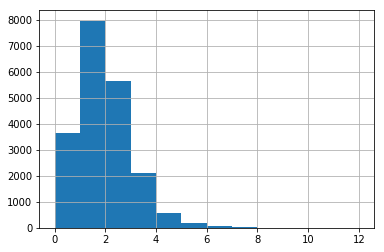

In [55]:
clas['num_boxes'].hist(bins=np.arange(13))

In [57]:
clas['user_name'].unique(), clas['user_name'].unique().shape

(array(['raspstephan', 'not-logged-in-b454def8ef12f0860686', 'ShCu',
        'bjorn.stevens', 'not-logged-in-6721fe35742a208c7ea5', 'lpaccini',
        'lkluft', 'DelaS', 'friedhelmjansen', 'Uthlande', 'jkiliani',
        'ReinhardB', 'JuleR', 'majomi', 'MarcusKlingebiel', 'dleutwyler',
        'biancorosa', 'TobiasBecker', 'bschul', 'Julia.Windmiller',
        'lutz.hirsch', 'Serikov', 'geetgeorge', 'jvmpi', 'cathyhohenegger',
        'not-logged-in-194b3b61c9c070c60365', 'jan.welss', 'heikekonow',
        'anna.luebke', 'onnoq', 'kfodor',
        'not-logged-in-acafbd8be3e0c307f3bf', 'christopher.moseley',
        'magio', 'not-logged-in-339a2150200b8eab9fb6', 'Saybot',
        'hartmut.borth', 'monika.esch', 'Armin.haghshenas',
        'not-logged-in-169bca65941805c9a058', 'elessar.telkontar',
        'Wolkengebilde', 'CStephan', 'traute.crueger', 'tmieslinger',
        'guidocioni', 'CKauhs', 'akio', 'bko_cloud', 'LWMPI', 'jpmellado',
        'stefankinne', 'bkirsch', 'double_p', '

In [59]:
clas['user_name'].value_counts()

jan.welss                             1053
guidocioni                             928
LWMPI                                  858
Serikov                                739
dleutwyler                             705
lpaccini                               592
hartmut.borth                          580
CStephan                               560
majomi                                 549
Uthlande                               530
bschul                                 529
lutz.hirsch                            522
Armin.haghshenas                       512
JuleR                                  505
cathyhohenegger                        475
monika.esch                            467
jkiliani                               459
bko_cloud                              458
magio                                  456
TobiasBecker                           456
Saybot                                 449
jpmellado                              430
onnoq                                  430
traute.crue

In [95]:
prac['user_name'].value_counts()

not-logged-in-339a2150200b8eab9fb6    87
ReinhardB                             83
not-logged-in-acafbd8be3e0c307f3bf    62
DelaS                                 59
Uthlande                              57
hartmut.borth                         57
monika.esch                           56
cathyhohenegger                       56
bschul                                56
majomi                                56
traute.crueger                        55
lpaccini                              55
TobiasBecker                          54
stefankinne                           54
Armin.haghshenas                      54
LWMPI                                 53
lkluft                                53
christopher.moseley                   53
heikekonow                            53
dleutwyler                            53
biancorosa                            52
anna.luebke                           52
Saybot                                52
guidocioni                            52
jan.welss       

## Basic exploration

### Distribution of labels

In [83]:
labels = pd.Series([l['tool_label'] for a in clas['annotations'] for l in a['value'] ])

In [84]:
len(labels)

29528

In [85]:
labels.value_counts()

Sugar     10816
Gravel     7439
Fish       6015
Flower     5258
dtype: int64

## Visualize labels

In [137]:
clas.head()

classification_id                           user_name    user_id  \
0          128465431                         raspstephan  1814911.0   
1          128490303  not-logged-in-b454def8ef12f0860686        NaN   
2          128623366                                ShCu  1830047.0   
3          128623455                                ShCu  1830047.0   
4          128623533                                ShCu  1830047.0   

                user_ip  workflow_id workflow_name  workflow_version  \
0  b454def8ef12f0860686         8072      Practice             19.13   
1  b454def8ef12f0860686         8072      Practice             24.13   
2  262955a3374c33958643         8072      Practice             24.13   
3  262955a3374c33958643         8072      Practice             24.13   
4  262955a3374c33958643         8072      Practice             24.13   

                created_at  gold_standard  expert  \
0  2018-10-24 17:02:45 UTC            NaN     NaN   
1  2018-10-24 18:57:11 UTC            NaN     NaN   
2  2018-10-25 16:49:06 UTC            NaN     NaN   
3  2018-10-25 16:49:36 UTC            NaN     NaN   
4  2018-10-25 16:50:08 UTC            NaN     NaN   

                                            metadata  \
0  {'source': 'api', 'session': '88559898111399b0...   
1  {'source': 'api', 'session': '87cebe5a5f8df494...   
2  {'source': 'api', 'session': '827957f6188eba83...   
3  {'source': 'api', 'session': '827957f6188eba83...   
4  {'source': 'api', 'session': '827957f6188eba83...   

                                         annotations  \
0  {'task': 'T0', 'task_label': 'Draw bounding bo...   
1  {'task': 'T0', 'task_label': 'Draw bounding bo...   
2  {'task': 'T0', 'task_label': 'Draw bounding bo...   
3  {'task': 'T0', 'task_label': 'Draw bounding bo...   
4  {'task': 'T0', 'task_label': 'Draw bounding bo...   

                                        subject_data  subject_ids  num_boxes  
0  {'26976393': {'retired': None, 'fn': '/project...     26976393          1  
1  {'26977308': {'retired': None, 'fn': '/project...     26977308          2  
2  {'26976669': {'retired': None, 'fn': '/project...     26976669          2  
3  {'26976422': {'retired': None, 'fn': '/project...     26976422          1  
4  {'26977225': {'retired': None, 'fn': '/project...     26977225          2

In [189]:
full = clas[clas['workflow_name'] == 'Full dataset']

In [190]:
full.drop(full.index[0], inplace=True)

/home/s/S.Rasp/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [191]:
full['datetime'] = pd.to_datetime(full['created_at'])

/home/s/S.Rasp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [192]:
full = full[full['datetime'].dt.date == np.datetime64('2018-11-02')]

In [194]:
full

classification_id      user_name    user_id               user_ip  \
559            129698655  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
623            129698824  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
717            129699083  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
781            129699257  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
809            129699340       jkiliani  1837012.0  0487d4d9788931868f3a   
847            129699448  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
866            129699509       jkiliani  1837012.0  0487d4d9788931868f3a   
882            129699549  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
910            129699620       jkiliani  1837012.0  0487d4d9788931868f3a   
925            129699673       jkiliani  1837012.0  0487d4d9788931868f3a   
948            129699739  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
966            129699789      jan.welss  1837022.0  e551ecd6265917094e8c   
969            129699799       jkiliani  1837012.0  0487d4d9788931868f3a   
975            129699812      jan.welss  1837022.0  e551ecd6265917094e8c   
988            129699848      jan.welss  1837022.0  e551ecd6265917094e8c   
1006           129699903      jan.welss  1837022.0  e551ecd6265917094e8c   
1017           129699937      jan.welss  1837022.0  e551ecd6265917094e8c   
1036           129699986      jan.welss  1837022.0  e551ecd6265917094e8c   
1049           129700030       jkiliani  1837012.0  0487d4d9788931868f3a   
1058           129700053      jan.welss  1837022.0  e551ecd6265917094e8c   
1065           129700074       jkiliani  1837012.0  0487d4d9788931868f3a   
1093           129700146      jan.welss  1837022.0  e551ecd6265917094e8c   
1096           129700156     biancorosa  1837436.0  b3bcd67523f4a0fa3444   
1102           129700174  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
1111           129700192       jkiliani  1837012.0  0487d4d9788931868f3a   
1118           129700210     biancorosa  1837436.0  b3bcd67523f4a0fa3444   
1128           129700236      jan.welss  1837022.0  e551ecd6265917094e8c   
1136           129700256     biancorosa  1837436.0  b3bcd67523f4a0fa3444   
1146           129700281     biancorosa  1837436.0  b3bcd67523f4a0fa3444   
1151           129700292  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
...                  ...            ...        ...                   ...   
20181          129755223    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20182          129755241    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20183          129755247         bschul  1837000.0  453d89e8d2c6926a9393   
20184          129755273         bschul  1837000.0  453d89e8d2c6926a9393   
20185          129755306         bschul  1837000.0  453d89e8d2c6926a9393   
20186          129755318    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20187          129755334    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20188          129755348         bschul  1837000.0  453d89e8d2c6926a9393   
20189          129755350    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20190          129755364    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20191          129755367         bschul  1837000.0  453d89e8d2c6926a9393   
20192          129755381         bschul  1837000.0  453d89e8d2c6926a9393   
20193          129755384    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20194          129755397         bschul  1837000.0  453d89e8d2c6926a9393   
20195          129755401    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20196          129755418         bschul  1837000.0  453d89e8d2c6926a9393   
20197          129755422       jkiliani  1837012.0  0487d4d9788931868f3a   
20198          129755439    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20199          129755457         bschul  1837000.0  453d89e8d2c6926a9393   
20200          129755460    lutz.hirsch  1837010.0  28e5711907d54bd94f66   
20201          129755477    lutz.hirsch  1837010.0  28e

In [195]:
full['fn'] = full.apply(lambda r: subj2fn[r['subject_ids']], axis=1)

In [196]:
full.head()

classification_id      user_name    user_id               user_ip  \
559          129698655  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
623          129698824  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
717          129699083  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
781          129699257  Wolkengebilde  1837084.0  35fc4ef4e1d74bcaaeda   
809          129699340       jkiliani  1837012.0  0487d4d9788931868f3a   

     workflow_id workflow_name  workflow_version               created_at  \
559         8073  Full dataset             13.11  2018-11-02 09:22:02 UTC   
623         8073  Full dataset             13.11  2018-11-02 09:23:19 UTC   
717         8073  Full dataset             13.11  2018-11-02 09:25:13 UTC   
781         8073  Full dataset             13.11  2018-11-02 09:26:25 UTC   
809         8073  Full dataset             13.11  2018-11-02 09:27:00 UTC   

     gold_standard  expert                                           metadata  \
559            NaN     NaN  {'source': 'api', 'session': '2215a91e8894f449...   
623            NaN     NaN  {'source': 'api', 'session': '2215a91e8894f449...   
717            NaN     NaN  {'source': 'api', 'session': '2215a91e8894f449...   
781            NaN     NaN  {'source': 'api', 'session': '2215a91e8894f449...   
809            NaN     NaN  {'source': 'api', 'session': 'ed0dd199477d6336...   

                                           annotations  \
559  {'task': 'T0', 'task_label': 'Draw bounding bo...   
623  {'task': 'T0', 'task_label': 'Draw bounding bo...   
717  {'task': 'T0', 'task_label': 'Draw bounding bo...   
781  {'task': 'T0', 'task_label': 'Draw bounding bo...   
809  {'task': 'T0', 'task_label': 'Draw bounding bo...   

                                          subject_data  subject_ids  \
559  {'27161669': {'retired': None, 'fn': '/project...     27161669   
623  {'27141017': {'retired': None, 'fn': '/project...     27141017   
717  {'27142943': {'retired': None, 'fn': '/project...     27142943   
781  {'27146483': {'retired': None, 'fn': '/project...     27146483   
809  {'27163964': {'retired': {'id': 24708912, 'wor...     27163964   

     num_boxes            datetime  \
559          3 2018-11-02 09:22:02   
623          2 2018-11-02 09:23:19   
717          3 2018-11-02 09:25:13   
781          3 2018-11-02 09:26:25   
809          2 2018-11-02 09:27:00   

                                                    fn  
559  /project/meteo/work/S.Rasp/cloud-classificatio...  
623  /project/meteo/work/S.Rasp/cloud-classificatio...  
717  /project/meteo/work/S.Rasp/cloud-classificatio...  
781  /project/meteo/work/S.Rasp/cloud-classificatio...  
809  /project/meteo/work/S.Rasp/cloud-classificatio...

In [197]:
from PIL import Image

In [201]:
full['fn'].iloc[0]

'/project/meteo/work/S.Rasp/cloud-classification/Region3_SON_Aqua/Aqua_CorrectedReflectance20161104_-135--114_-15--1.jpeg'

In [203]:
from collections import defaultdict

In [209]:
subjects = list(subj2fn.keys())

In [ ]:
full

In [207]:
annos = defaultdict(list)
for i, r in full.iterrows():
    for a in r['annotations']['value']:
        annos[r['subject_ids']].append([
            r['user_name'],
            [a['x'], a['y'], a['width'], a['height']],
            a['tool_label']
        ])

In [208]:
annos

defaultdict(list,
            {27161669: [['Wolkengebilde',
               [437.4206237792969,
                529.5433959960938,
                547.6867370605469,
                427.69879150390625],
               'Fish'],
              ['Wolkengebilde',
               [330.979736328125,
                10.88599967956543,
                661.8687744140625,
                508.98094367980957],
               'Fish'],
              ['Wolkengebilde',
               [32.94526672363281,
                7.0154218673706055,
                298.0344696044922,
                911.5210161209106],
               'Flower'],
              ['bkirsch',
               [1155.0152587890625,
                29.077239990234375,
                818.6597900390625,
                742.0061340332031],
               'Sugar']],
             27141017: [['Wolkengebilde',
               [479.99688720703125,
                860.477783203125,
                1014.0912475585938,
                489.6280517578125]

In [234]:
s = 27146483

In [235]:
img = Image.open(subj2fn[s])

In [276]:
annos[s]

[['dleutwyler',
  [8.278488159179688,
   193.11578369140625,
   332.6763153076172,
   401.66448974609375],
  'Sugar'],
 ['biancorosa',
  [68.48834991455078, 583.667724609375, 1466.0806198120117, 374.546142578125],
  'Fish'],
 ['biancorosa',
  [113.96895599365234,
   217.14761352539062,
   1495.5091934204102,
   248.80560302734375],
  'Sugar'],
 ['biancorosa',
  [199.57949829101562, 1057.2010498046875, 783.8716125488281, 318.3642578125],
  'Sugar'],
 ['LWMPI',
  [-9.742172241210938,
   166.96774291992188,
   1516.189682006836,
   471.1997375488281],
  'Sugar']]

In [237]:
annos[s][0][1]

[56.168731689453125, 316.66162109375, 522.5279846191406, 545.75146484375]

In [238]:
import matplotlib.patches as patches

In [274]:
s = subjects[5009]

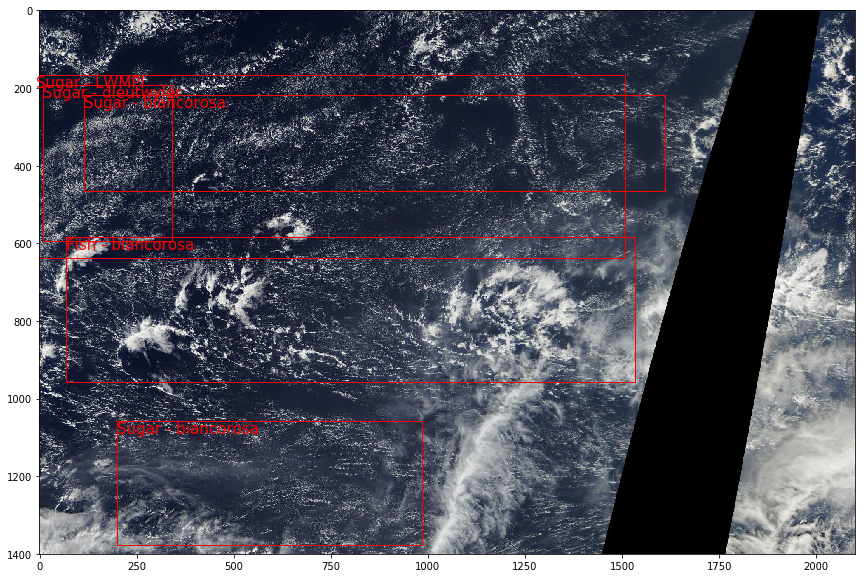

In [277]:
fig, ax = plt.subplots(figsize=(15, 10))
img = Image.open(subj2fn[s])
ax.imshow(img)
for a in annos[s]:
    coords = a[1]
    rect = patches.Rectangle((coords[0],coords[1]), coords[2], coords[3], facecolor='none', edgecolor='r')
    ax.add_patch(rect)
    ax.text(coords[0],coords[1], a[2] + ' - ' + a[0], color='red', fontsize=15, va='top')

In [ ]:
labels = pd.Series([l['tool_label'] for a in clas['annotations'] for l in a['value'] ])

In [205]:
full['annotations'].iloc[0]

{'task': 'T0',
 'task_label': 'Draw bounding boxes around cloud regions',
 'value': [{'x': 437.4206237792969,
   'y': 529.5433959960938,
   'tool': 2,
   'frame': 0,
   'width': 547.6867370605469,
   'height': 427.69879150390625,
   'details': [],
   'tool_label': 'Fish'},
  {'x': 330.979736328125,
   'y': 10.88599967956543,
   'tool': 2,
   'frame': 0,
   'width': 661.8687744140625,
   'height': 508.98094367980957,
   'details': [],
   'tool_label': 'Fish'},
  {'x': 32.94526672363281,
   'y': 7.0154218673706055,
   'tool': 1,
   'frame': 0,
   'width': 298.0344696044922,
   'height': 911.5210161209106,
   'details': [],
   'tool_label': 'Flower'}]}